# WeatherGami
## Written By Jared Rennie (@jjrennie)

Ever hear of a scorigami? It's an event in sports where a final score has never happened in its history. For example, in the <a href='https://nflscorigami.com/' target="_blank">National Football League</a>, a 20-17 score has happened over 285 times, but a 70-20 score has only happened once. When the Miami Dolphins beat the Denver Broncos 70-20 on September 24th, 2023, that was considered a scorigami!

Well, inspired by this, Jonathan Kahl wrote an <a href='https://journals.ametsoc.org/view/journals/bams/104/10/BAMS-D-23-0035.1.xml' target="_blank">article</a> in the Bulletin of the American Meteorological Society describing the concept of 'WeatherGami', utilizing the days Maximum and Minimum temperature at a given area. Since <a href='https://www.ncei.noaa.gov' target="_blank">NOAA NCEI</a> holds all of the worlds weather data, it makes sense to see how WeatherGami works on their station database. This code does that! 

### What You Need

First off, the entire codebase works in Python 3. In addition to base Python, you will need the following packages installed: 
- requests (to access the api)
- pandas (to slice annd dice the data)
- matplotlib (to plot!)
    
The "easiest" way is to install these is by installing <a href='https://www.anaconda.com' target="_blank">anaconda</a>, and then applying <a href='https://conda-forge.org/' target="_blank">conda-forge</a>. Afterward, then you can install the above packages. 

### Importing Packages
Assuming you did the above, it should (in theory) import everything no problem:

In [1]:
# Import packages
%matplotlib inline
import json,requests,sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
print("SUCCESS!")

SUCCESS!


If you made it this far, great!

### Insert Arguments
To access the data, we will be utilizing the <a href='https://www.rcc-acis.org/docs_webservices.html' target='blank'>ACIS API</a>, which is a quick and easy way to access our station data without having to download it yourself. Now we need to know what station to get data for. The ACIS API accepts all sorts of IDs, including:

- FAA (i.e. AVL)
- ghcn (i.e. USW00003812)
- ThreadEx (i.e. AVLthr)

If you're not sure, you can refer to the API documentation above. We also need a max/min combo for us to check against the database. And finally we need to give you credit for the image that is created at the end. 

 **Change the arguments below to your liking**

In [2]:
# Insert Arguments Here
stationID = 'AVL'
inTmax= '75'
inTmin= '45'
author='Not Jared Rennie'

The rest of the code should work without making any changes to it, but if you're interested, keep on reading to see how the sausage is made.

This next block of code will attempt to access the data we want from the ACIS API. The API is publicly available, but sometimes there are hiccups when getting the data. We tried to account for this with a try/exept in this code block and it will let you know if it fails after 3 seconds. If this happens, wait a minute, then try again.

In [3]:
# Format input max/min for API call
inTmax= "%.1f" % (int(inTmax))
inTmin= "%.1f" % (int(inTmin))

# Build JSON to access ACIS API (from https://www.rcc-acis.org/docs_webservices.html)
acis_url = 'http://data.rcc-acis.org/StnData'
payload = {
"output": "json",
"params": {"elems":[{"name":"maxt","interval":"dly","prec":1},{"name":"mint","interval":"dly","prec":1}],
           "sid":stationID,
           "sdate":"por",
           "edate":"por"
          } 
}

# Make Request
try:
    r = requests.post(acis_url, json=payload,timeout=3)
    acisData = r.json()
    print("SUCCESS!")
except Exception as e:
	sys.exit('\nSomething Went Wrong With Accessing API after 3 seconds, Try Again')

SUCCESS!


If it says "SUCCESS!" then congrats you got the data!

### Let's check the data!
How does it look? Well the data comes back as a JSON, which can be a little confusing to look at, so let's extract the information we need, and reorganize it a bit.

First, the JSON has a 'meta' key and a 'data' key. The 'meta' key gets us info like station name, latitude, longitude, etc. And 'data' is the actual data we requested. So let's get some station info, and convert the data into a pandas dataframe, which makes it easier to see. 

In [4]:
# Get Station Info
stationName=acisData['meta']['name'].title()
stationState=acisData['meta']['state']

# Convert data into Pandas DataFrame
acisPandas = pd.DataFrame(acisData['data'], columns=['Date','Tmax','Tmin'])

print("\nSuccessfully Orgainzed Data for: ",stationName,',',stationState)
print(acisPandas)


Successfully Orgainzed Data for:  Asheville Regional Airport , NC
             Date  Tmax  Tmin
0      1946-01-01  29.0  12.0
1      1946-01-02  41.0   8.0
2      1946-01-03  43.0  30.0
3      1946-01-04  58.0  29.0
4      1946-01-05  55.0  40.0
...           ...   ...   ...
28440  2023-11-13  68.0  34.0
28441  2023-11-14  65.0  43.0
28442  2023-11-15  57.0  41.0
28443  2023-11-16  68.0  44.0
28444  2023-11-17  64.0  48.0

[28445 rows x 3 columns]


Sometimes people want to know what the station's period of record is, so let's get that info. 

In [5]:
stationStart=acisPandas.iloc[[0]]['Date'].values[0][0:4]
stationEnd=acisPandas.iloc[[-1]]['Date'].values[0][0:4]
print("Period of Record: ",stationStart,"-",stationEnd)

Period of Record:  1946 - 2023


### Cool, but is it a WeatherGami?
Let's find out! We can use some pandas calls to see if our max/min input has happened in the record before. This code block will tell you if it's a WeatherGami or not. If not, it will tell you the other times it has happened in the record. Here, we define a WeatherGami as either happening once before, or not at all.

In [6]:
# Now Find if the Tmax/Tmin combo has happened in the record before (ie WeatherGami).
wgTest=acisPandas[(acisPandas['Tmax'] == inTmax) & (acisPandas['Tmin']==inTmin)]

if len(wgTest) == 0:
    wgResult="It's a WeatherGami!"
    print(inTmax,'/',inTmin,': ',wgResult)
    print("It has never happened before!")
elif len(wgTest) == 1:
    wgResult="It's a WeatherGami!"
    print(inTmax,'/',inTmin,': ',wgResult)
    print("It has happened ",len(wgTest)," time before")
    print(wgTest)
else:
    wgResult="It's NOT a WeatherGami!"
    print(inTmax,'/',inTmin,': ',wgResult)
    print("It has happened ",len(wgTest)," times before")
    print(wgTest)

75.0 / 45.0 :  It's NOT a WeatherGami!
It has happened  14  times before
             Date  Tmax  Tmin
270    1946-09-28  75.0  45.0
279    1946-10-07  75.0  45.0
291    1946-10-19  75.0  45.0
8186   1968-05-31  75.0  45.0
9617   1972-05-01  75.0  45.0
12174  1979-05-02  75.0  45.0
13660  1983-05-27  75.0  45.0
14738  1986-05-09  75.0  45.0
17796  1994-09-22  75.0  45.0
20023  2000-10-27  75.0  45.0
20348  2001-09-17  75.0  45.0
22567  2007-10-15  75.0  45.0
26020  2017-03-29  75.0  45.0
27522  2021-05-09  75.0  45.0


The other thing we might want to know is the frequency, or percentage of time a max/min combo occurrs. The followig code block does this for all combinations, and prints out the most common. We also need to weed out missing data at this point, which is recogized as 'M' by the API

In [7]:
# Get Frequency and Percentage Info needed for Plotting
frequency_counts = acisPandas.groupby(['Tmax', 'Tmin']).size().reset_index(name='Frequency')
frequency_counts['Percentage'] = (frequency_counts['Frequency'] / len(acisPandas)) * 100

# Remove Missing Data
frequency_counts=frequency_counts[(frequency_counts['Tmax']!='M') & (frequency_counts['Tmin']!='M')].sort_values('Percentage', ascending=True)

# Get Frequency of input tmax/tmin and most frequent
currFreq=frequency_counts[(frequency_counts['Tmax'] == inTmax) & (frequency_counts['Tmin']==inTmin)]
if len(currFreq)==0:
    currFreq=str(inTmax)+'/'+str(inTmin)+': '+wgResult+' (It has never happened before!)'
elif currFreq['Frequency'].values[0]==1:
    currFreq=str(inTmax)+'/'+str(inTmin)+': '+wgResult+' ('+str(currFreq.iloc[-1]['Frequency'])+' Occurrence)'
else:
    currFreq=str(inTmax)+'/'+str(inTmin)+': '+wgResult+' ('+str(currFreq.iloc[-1]['Frequency'])+' Occurrences)'
mostFreq=str(frequency_counts.iloc[-1]['Tmax'])+'/'+str(frequency_counts.iloc[-1]['Tmin'])+' ('+str(frequency_counts.iloc[-1]['Frequency'])+' Occurrences)'

print('Most Frequent: ',mostFreq)

Most Frequent:  84.0/64.0 (86 Occurrences)


Now for the fun part...

### Plotting the data!

This block of code will take the max/min combos and plot it, and colorize it by frequency. A red dot will also plot with the max/min combo given as an input. Feel free to play around with this block to adjust the plotting style.

PLOTTING


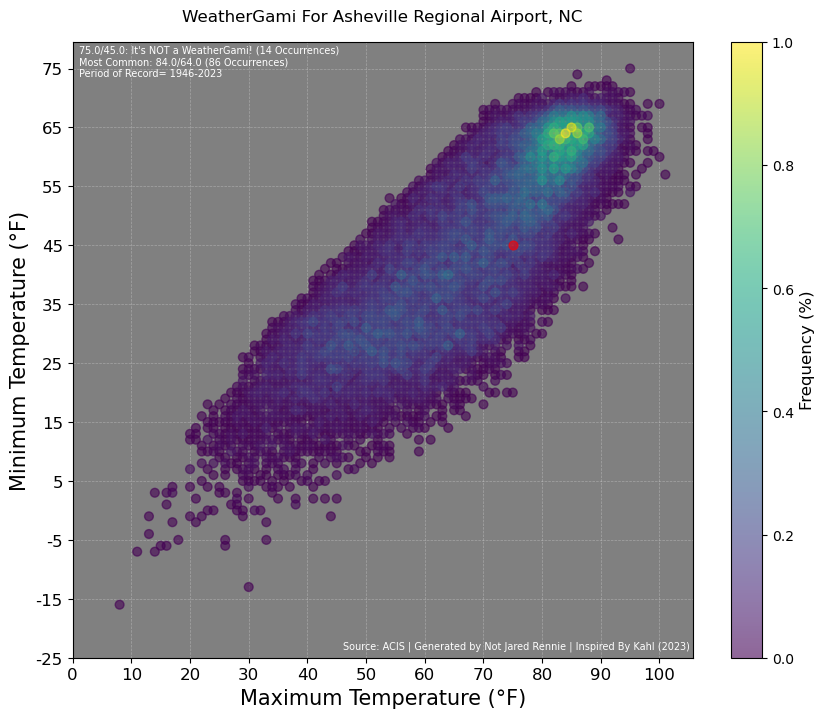

In [8]:
# Plot
print("PLOTTING")

# Set up the scatter plot
dpi=100
fig, axf = plt.subplots(figsize=(10, 8), dpi=dpi)

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
axf.set_facecolor('#808080')

# Sort and Extract the values from the DataFrame
tmax_values = frequency_counts['Tmax'].astype('f')
tmin_values = frequency_counts['Tmin'].astype('f')
percentage = frequency_counts['Percentage'].astype('f')

# Plot the tmax/tmin locationns, colorized by percentage. Also plot input tmax/tmiin as separate color
plt.scatter(tmax_values, tmin_values, c=percentage, cmap='viridis', s=40, alpha=0.6,zorder=9)
plt.scatter(float(inTmax), float(inTmin), c='red',s=40, alpha=0.6,zorder=10)

# Get X/Y Limits to help with plotting axes
ymin=int(5 * round(float((min(tmin_values) - 10))/5))
ymax=int(5 * round(float((max(tmin_values) + 10))/5))
xmin=int(5 * round(float((min(tmax_values) - 10))/5))
xmax=int(5 * round(float((max(tmax_values) + 10))/5))

# Plot X/Y-Axis Label
plt.yticks(range(ymin, ymax, 10), [r'{}'.format(x) for x in range(ymin, ymax, 10)], fontsize=12, color='black')
plt.ylabel(r'Minimum Temperature (°F)', fontsize=15, color='black')
plt.xticks(range(xmin, xmax, 10), [r'{}'.format(x) for x in range(xmin, xmax, 10)], fontsize=12, color='black')
plt.xlabel(r'Maximum Temperature (°F)', fontsize=15, color='black')

# Plot Title/Subtitle/Annotations
plt.title('WeatherGami For '+stationName+', '+stationState, fontsize=12,y=1.02,color='black')
plt.annotate('Source: ACIS | Generated by '+author+' | Inspired By Kahl (2023)',xy=(0.995, 0.01), xycoords='axes fraction', fontsize=7,horizontalalignment='right', verticalalignment='bottom',color='white')
plt.annotate(currFreq+'\nMost Common: '+mostFreq+'\nPeriod of Record= '+str(stationStart)+'-'+str(stationEnd),xy=(0.01, 0.995), xycoords='axes fraction', fontsize=7,horizontalalignment='left', verticalalignment='top',color='white')

# Add labels and a colorbar
cbar = plt.colorbar(orientation='vertical')
cbar.set_label('Frequency (%)',fontsize=12)

# Show Figure
plt.show()

Isn't it beautiful? Congrats! You made a WeatherGami plot! Feel free to post on social media for the world to see!

**Congrats on completing this notebook! Now go forth and make better plots!**